### The goal of this project is to predict the Crude Oil prices. Monthly petroleum prices can be found at the [Energy Information Administration](https://www.eia.gov/dnav/pet/pet_pri_spt_s1_m.htm). Ever relevant, [Wikipedia](https://en.wikipedia.org/wiki/World_oil_market_chronology_from_2003) has a great write-up on recent trends in oil prices. Also, there is this [Times](http://content.time.com/time/business/article/0,8599,1859380,00.html) article on the spike and drop in 2008.

### Introduction:

Tthere are different types of crude oil – the thick, unprocessed liquid that drillers extract below the earth – and some are more desirable than others. Also, where the oil comes from also makes a difference. Because of these nuances, we need benchmarks to value the commodity based on its quality and location. Thus, Brent, WTI and Dubai/Oman serve this important purpose. Here, I use the most important WTI to demonstrate the world crude oil price changes.

West Texas Intermediate (WTI) – WTI refers to oil extracted from wells in the U.S. and sent via pipeline to Cushing, Oklahoma. The product itself is very light and very sweet, making it ideal for gasoline refining, in particular. WTI continues to be the main benchmark for oil consumed in the United States. Brent Blend – Roughly two-thirds of all crude contracts around the world reference Brent Blend, making it the most widely used marker of all. These days, “Brent” actually refers to oil from four different fields in the North Sea: Brent, Forties, Oseberg and Ekofisk. Crude from this region is light and sweet, making them ideal for the refining of diesel fuel, gasoline. For more information see [Wikipedia](https://en.wikipedia.org/wiki/West_Texas_Intermediate) article. 
 

In [1]:
# Import required packages

%matplotlib inline
import matplotlib
import seaborn as sns
import quandl
import math
import numpy as np
import scipy as sp
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# Time Series
<!-- requirement: images/ts_xval.png -->
<!-- requirement: projects/timeseries-project -->

Time series prediction or forecasting presents its own challenges which are different from machine-learning problems.  

Let's first define our time-series as

$$ \{X_t, t = \ldots, -1, 0, 1, \ldots\} \, . $$

In general, while we could use regression to make predictions, the goal of time series analysis is to take advantage of the temporal nature of the data to make more sophisticated models.

**Why not regression** : In typical time series analysis, the depended variables are missing. For exmaple, a simple linear regression would take a form of 

$$ Y = \beta_0 + \beta_1 X_1 + ...$$

where X_1, X_2 ... are unknown. All we know is Y as a function of time.

Here are a few concepts related to time series.  We take $\varepsilon \sim N(0, \sigma^2)$ to be i.i.d. normal errors.  
1. **Stationarity**.  Informally, this means that the distribution of the $X_t$ is independent of time $t$.  Formally, a time-series is stationary if for all $k \ge 0$ and $t$, the following two $k$-tuples have the same distribution:
$$ (X_0,\ldots,X_k) \sim (X_t,\ldots,X_{t+k}) $$
1. **Drift**.  One reason a time-series might not be stationary is that it possess a drift.  For example, we know that prices tend to creep up with inflation.  Mathematically, we might represent the (log) prices as
$$ X_t = \mu t + \varepsilon_t $$
1. **Seasonality**.  Another reason a time-series might not be stationary is that it posseses a seasonal component.  For example, we know that the temperature increases in the summer and decreases in the winter.  A simple model of this might be
$$ X_t = \alpha \sin(\omega t) + \beta \cos(\omega t)$$


### Get Crudeoil price dataset

In [2]:
oil = quandl.get("CHRIS/CME_CL1")  # This creates pandas data frame

In [3]:
oil.tail(5)

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2017-06-30,44.89,46.35,44.88,46.33,1.11,46.04,674176.0,519676.0
2017-07-03,46.28,47.10,45.92,47.05,1.03,47.07,513672.0,517659.0
2017-07-05,47.04,47.32,44.51,45.61,1.94,45.13,1167208.0,510718.0
2017-07-06,45.65,46.53,45.18,45.33,0.39,45.52,945108.0,487969.0
2017-07-07,45.35,45.42,43.78,44.33,1.29,44.23,958132.0,448574.0


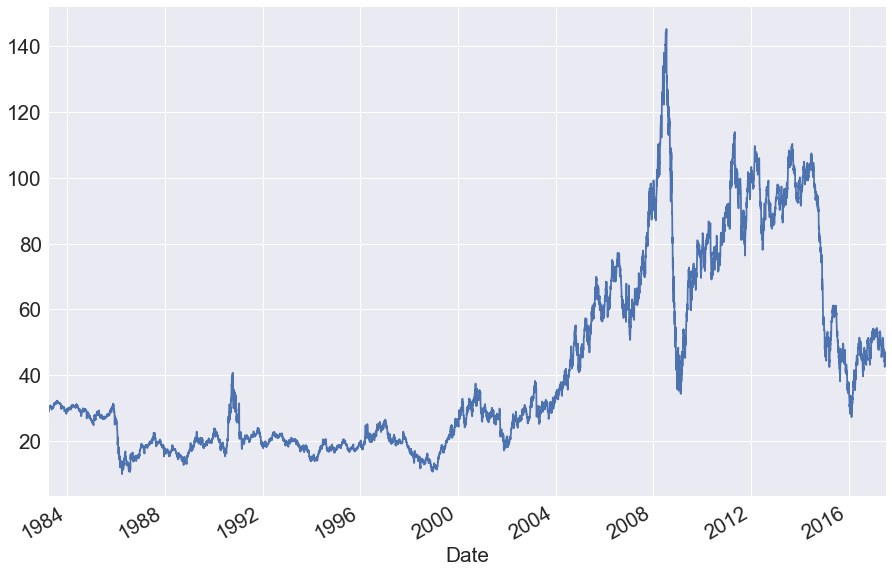

In [4]:
oil.Open.plot()

In [5]:
# Setting the random seed

np.random.seed(7)
dataset = oil.Open.values
dataset = dataset.astype('float32')
dataset

array([ 29.01000023,  29.39999962,  29.29999924, ...,  47.04000092,
        45.65000153,  45.34999847], dtype=float32)

In [6]:
# normalize the dataset

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([ 0.14061689,  0.14350173,  0.14276204, ...,  0.27398476,
        0.26370293,  0.26148382], dtype=float32)

In [7]:
# Split the datser into test and training data

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

(6027, 2584)


Write a simple function to convert single column of data into a two-column dataset. The first column containing today's (t) price and the second column containing next day’s (t+1) price and so on, to be predicted.

In [22]:
# convert an array of values into a dataset matrix
# look_back = number of features. Use ACF and PACF to determine this

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

For this problem, I inspected ACF and PACF to determine look_back ~ 12.

## Long Short-Term Memory (LSTM) Recurrent Network for Regression

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [23]:
# reshape into X=t and Y=t+1

look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [24]:
trainX.shape

(6015, 12)

In [25]:
# reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [26]:
trainX.shape

(6015, 1, 12)

In [27]:
# create and fit the LSTM network

model_LSTM = Sequential()
model_LSTM.add(LSTM(13, input_shape=(1, look_back)))
model_LSTM.add(Dense(1))
model_LSTM.compile(loss='mean_squared_error', optimizer='adam')
model_LSTM.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
30s - loss: 2.9997e-04
Epoch 2/20
29s - loss: 7.6833e-05
Epoch 3/20
29s - loss: 6.3019e-05
Epoch 4/20
29s - loss: 5.2739e-05
Epoch 5/20
29s - loss: 4.8446e-05
Epoch 6/20
30s - loss: 4.8699e-05
Epoch 7/20
29s - loss: 4.8397e-05
Epoch 8/20
29s - loss: 4.4940e-05
Epoch 9/20
29s - loss: 4.3124e-05
Epoch 10/20
29s - loss: 4.3059e-05
Epoch 11/20
31s - loss: 4.2391e-05
Epoch 12/20
30s - loss: 4.3402e-05
Epoch 13/20
29s - loss: 4.1792e-05
Epoch 14/20
29s - loss: 4.1057e-05
Epoch 15/20
29s - loss: 3.9990e-05
Epoch 16/20
29s - loss: 3.9415e-05
Epoch 17/20
29s - loss: 4.0692e-05
Epoch 18/20
29s - loss: 3.9444e-05
Epoch 19/20
29s - loss: 3.9506e-05
Epoch 20/20
29s - loss: 3.7066e-05


In [44]:
# make predictions
trainPredict = model_LSTM.predict(trainX)
testPredict = model_LSTM.predict(testX)

In [45]:
testPredict[0]

array([ 0.41412175], dtype=float32)

In [37]:
len(testY)

2572

In [36]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_val = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_val = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_val[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_val[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.80 RMSE
Test Score: 3.36 RMSE


/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


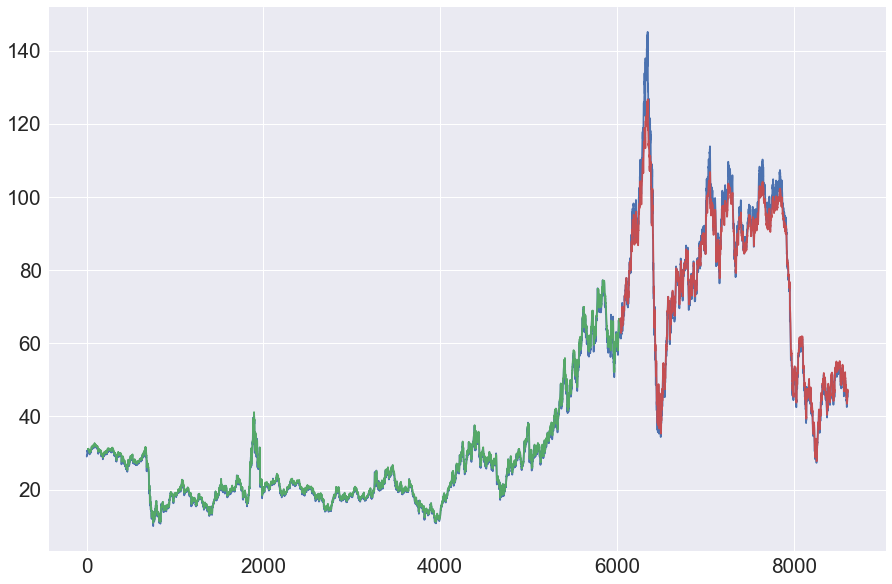

In [42]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict.ravel()

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset)] = testPredict.ravel()

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [61]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

# reshape dataset
look_back = 12
trainX_mpm, trainY_mpm = create_dataset(train, look_back)
testX_mpm, testY_mpm = create_dataset(test, look_back)

In [62]:
testX_mpm.shape

(2572, 12)

In [63]:
# create and fit Multilayer Perceptron model

model_MPM = Sequential()
model_MPM.add(Dense(14, input_dim=look_back, activation='relu')) # input layer with 14 neurons 
model_MPM.add(Dense(8, activation='relu')) # Second Layer
model_MPM.add(Dense(1)) 
model_MPM.compile(loss='mean_squared_error', optimizer='adam')
model_MPM.fit(trainX_mpm, trainY_mpm, epochs=50, batch_size=2, verbose=2)

Epoch 1/50
4s - loss: 9.3823e-04
Epoch 2/50
4s - loss: 5.4111e-05
Epoch 3/50
4s - loss: 5.2842e-05
Epoch 4/50
4s - loss: 5.1203e-05
Epoch 5/50
4s - loss: 4.9231e-05
Epoch 6/50
4s - loss: 4.5481e-05
Epoch 7/50
4s - loss: 4.6111e-05
Epoch 8/50
4s - loss: 4.3892e-05
Epoch 9/50
4s - loss: 4.3274e-05
Epoch 10/50
4s - loss: 4.4122e-05
Epoch 11/50
4s - loss: 4.0554e-05
Epoch 12/50
4s - loss: 4.1522e-05
Epoch 13/50
4s - loss: 3.9927e-05
Epoch 14/50
4s - loss: 4.0404e-05
Epoch 15/50
4s - loss: 3.9615e-05
Epoch 16/50
4s - loss: 3.8948e-05
Epoch 17/50
4s - loss: 3.7841e-05
Epoch 18/50
4s - loss: 3.8700e-05
Epoch 19/50
4s - loss: 3.8000e-05
Epoch 20/50
4s - loss: 3.6936e-05
Epoch 21/50
4s - loss: 3.7526e-05
Epoch 22/50
4s - loss: 3.7123e-05
Epoch 23/50
4s - loss: 3.8259e-05
Epoch 24/50
4s - loss: 3.7794e-05
Epoch 25/50
4s - loss: 3.5653e-05
Epoch 26/50
4s - loss: 3.4740e-05
Epoch 27/50
4s - loss: 3.8298e-05
Epoch 28/50
4s - loss: 3.8657e-05
Epoch 29/50
4s - loss: 3.4989e-05
Epoch 30/50
4s - loss: 

In [64]:
# make predictions
trainPredict_mpm = model_MPM.predict(trainX_mpm)
testPredict_mpm = model_MPM.predict(testX_mpm)

# invert predictions
trainPredict_mpm = scaler.inverse_transform(trainPredict_mpm)
trainY_mpm = scaler.inverse_transform([trainY_mpm])
testPredict_mpm = scaler.inverse_transform(testPredict_mpm)
testY_mpm = scaler.inverse_transform([testY_mpm])

# calculate root mean squared error
trainScore_mpm = math.sqrt(mean_squared_error(trainY_mpm[0], trainPredict_mpm[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_mpm))
testScore_mpm = math.sqrt(mean_squared_error(testY_mpm[0], testPredict_mpm[:,0]))
print('Test Score: %.2f RMSE' % (testScore_mpm))

Train Score: 0.70 RMSE
Test Score: 1.81 RMSE


/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


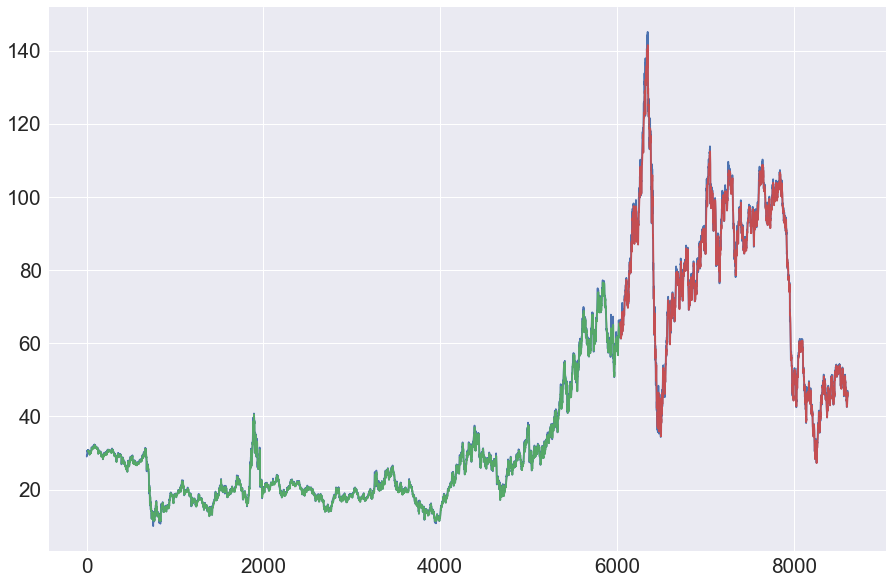

In [65]:
# shift train predictions for plotting
trainPredictPlot_mpm = np.empty_like(dataset)
trainPredictPlot_mpm[:] = np.nan
trainPredictPlot_mpm[look_back:len(trainPredict_mpm)+look_back] = trainPredict_mpm.ravel()

# shift test predictions for plotting
testPredictPlot_mpm = np.empty_like(dataset)
testPredictPlot_mpm[:] = np.nan
testPredictPlot_mpm[len(trainPredict_mpm)+(look_back*2):len(dataset)] = testPredict_mpm.ravel()

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot_mpm)
plt.plot(testPredictPlot_mpm)
plt.show()

In [82]:
testY_mpm[0][-12:]

array([ 43.380002  ,  42.5500007 ,  42.79999867,  43.15999976,
        43.4900011 ,  43.69999939,  44.88999775,  44.88999775,
        46.27999851,  47.04000038,  45.64999962,  45.34999803])

In [84]:
x = np.reshape(testY_mpm[0][-12:],(1,12))

In [85]:
x

array([[ 43.380002  ,  42.5500007 ,  42.79999867,  43.15999976,
         43.4900011 ,  43.69999939,  44.88999775,  44.88999775,
         46.27999851,  47.04000038,  45.64999962,  45.34999803]])

In [86]:
model_MPM.predict(x)

array([[ 43.44081116]], dtype=float32)